---
title: "Full report on Borzoi performance analysis"
author: "Sofia Salazar, Sabrina Mi"
date: "2023-10-25"
description: 'Full report on the assesment of borzoi performance against Enformer'
categories: [analysis, report]
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    code-tools: true
    code-overflow: wrap
editor_options: 
  chunk_output_type: console
---

# Introduction

In this notebook, we explored the question: **Does borzoi predictions have a better performance compared to Enformer, at predicting cross-population expression for the CAGE LCL tracks?**

**Sofia's Analysis** involved comparisons between observed and predicted expression 136 of the top-performing genes for enformer and 140 of the worst-performing genes for enformer (total 276 genes). She sampled 100 individuals from the Geuvadis dataset for both borzoi and enformer predictions


**Sabrina's Analysis** predicted gene expression for 100 randomly-sampled genes across all 455 Geuvadis samples.


For both experiments, we compared the correlation between the predictions using both tools, and the ground truth measurements of the Geuvadis gene expression for the same individuals as the prediction. We examined correlations with the ground truth as a measure of performance.

# Sofia's Analysis

## Libraries

In [1]:
import pandas as pd
import numpy as np
import h5py
import kipoiseq
import matplotlib.pyplot as plt
import re

## Data

In [2]:
DATA = '/home/t-9ssal0/data/'
PROJECT = '/project2/haky/sofia/borzoiRun/'
geuvadis_file = DATA + 'geuvadis_expression.gz'
geuvadis_gene_expression = pd.read_table(geuvadis_file, sep='\t',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})
individuals_file = pd.read_csv(PROJECT + 'my_individuals.tsv', sep = '\t')
individuals = individuals_file['Individuals'].to_list()

Loading gene lists for both analysis

In [3]:
best_predicted_genes_df = pd.read_csv('/project2/haky/sofia/borzoiRun/predicted_genes_20oct.csv', header=None)
best_my_genes = best_predicted_genes_df[0].to_list() # 136 best performing genes

gene_list = []
for i in range(1, 8):
    genes_file = pd.read_csv(f'{PROJECT}gene_lists/worst_list{i}.csv')
    gene_list.append(genes_file['x'].to_list())
worst_my_genes = [item for sublist in gene_list for item in sublist] # 140 worst performing genes

## Functions

In [4]:
def get_genes_per_file(num_files, type):
    file_type = "" if type.lower() == "best" else "fast_"
    predicted_genes = []
    all_genes = []
    for s in range(1, num_files + 1):
        # assuming both files have the same genes
        with h5py.File('/scratch/midway3/t-9ssal0/h5_files/'+file_type+'enformer_predictions' +str(s)+ '.h5', 'r') as file:
            group = file[individuals[0]]
            predicted_genes.append(list(group.keys()))
    for l in predicted_genes:
        all_genes.append(list((set([re.sub(r"_haplo\d+", "", s) for s in l]))))
    return(all_genes)

best_genes_per_file = get_genes_per_file(7, "best")
worst_genes_per_file = get_genes_per_file(7, "worst")

Note: moved all h5 files to /cds/haky/sofia/h5_files/

In [5]:
def get_expression_dic(number_files, software, type, genes_per_file):
    file_type = "" if type.lower() == "best" else "fast_"
    expression_dic = {k:{} for k in individuals}
    start_bin = 0 if software.lower() == 'borzoi' else 3
    end_bin = 17 if software.lower() == 'borzoi' else 7
    index = [870, 871] if software.lower()== 'borzoi' else 5110
    for individual in individuals:
        gene_expr = {}
        for file_num in range(1, number_files + 1):
            with h5py.File('/scratch/midway3/t-9ssal0/h5_files/'+file_type + software.lower() + '_predictions'+ str(file_num)+ '.h5', 'r') as file:
                for gene in genes_per_file[file_num - 1]: #iterate through genes in file
                    group = file[individual]
                    expression = 0
                    for h in range(0,2): # iterate through haplotypes
                        prediction = group[f'{gene}_haplo{h}'][:, index]
                        if software.lower() == 'borzoi':
                            prediction = np.mean(prediction, axis = (1)) # mean over track replicates
                        expression += np.mean(prediction[start_bin: end_bin])
                    gene_expr[gene] = expression
                    del prediction
        expression_dic[individual] = gene_expr
    return expression_dic


def get_predictions_across_indiv(expression_dic, genes):
    predictions_across_ind = {gene:[] for gene in genes}
    for individual in expression_dic:
        for gene in genes:
            predictions_across_ind[gene].append(expression_dic[individual][gene])
    return predictions_across_ind

def get_correlations(dic1, dic2):
    corr = {gene: np.empty(len(individuals)) for gene in dic1.keys()}
    for gene in dic1.keys():
        col_corr = np.corrcoef(dic1[gene], dic2[gene])[0,1]
        corr[gene] = col_corr
    return(corr)

## First analysis: performance comparison in best-performing genes with Enformer

#### Get expression across individuals for each gene

In [7]:
best_expression_borzoi_dic = get_expression_dic(7, 'borzoi', 'best', best_genes_per_file)
best_expression_enformer_dic = get_expression_dic(7, 'enformer', 'best', best_genes_per_file)

best_borzoi_across_individuals = get_predictions_across_indiv(best_expression_borzoi_dic, best_my_genes)
best_enformer_across_individuals = get_predictions_across_indiv(best_expression_enformer_dic, best_my_genes)

Geuvadis data

In [10]:
geuvadis = geuvadis_gene_expression.loc[geuvadis_gene_expression['gene_name'].isin(best_my_genes)]
geuvadis.index = geuvadis['gene_name']
geuvadis = geuvadis.loc[:, individuals]
geuvadis = geuvadis.loc[best_my_genes]
best_GT_across = {gene:val for gene, val in zip(best_my_genes, geuvadis.values.tolist())}

#### Correlations

In [11]:
best_corr_borzoi_enf = get_correlations(best_borzoi_across_individuals, best_enformer_across_individuals)
best_corr_enf_GT = get_correlations(best_enformer_across_individuals, best_GT_across)
best_corr_bor_GT = get_correlations(best_borzoi_across_individuals, best_GT_across)

#### Correlations between enformer and borzoi predictions

In [12]:
best_df_enf_bor = pd.DataFrame({'Correlations': best_corr_borzoi_enf,
                           'abs_Correlations':best_corr_borzoi_enf})
best_df_enf_bor['abs_Correlations'] = abs(best_df_enf_bor['abs_Correlations'])
best_df_enf_bor.head(10)

,Correlations,abs_Correlations
CDC16,0.824303,0.824303
DPYSL4,0.725614,0.725614
ZFAND2A,-0.945341,0.945341
DCAF4,0.221603,0.221603
ZFYVE19,0.560699,0.560699
MCOLN2,0.664648,0.664648
XRRA1,0.864334,0.864334
TTLL12,0.821124,0.821124
USP40,0.959084,0.959084
UGT2B17,0.989967,0.989967


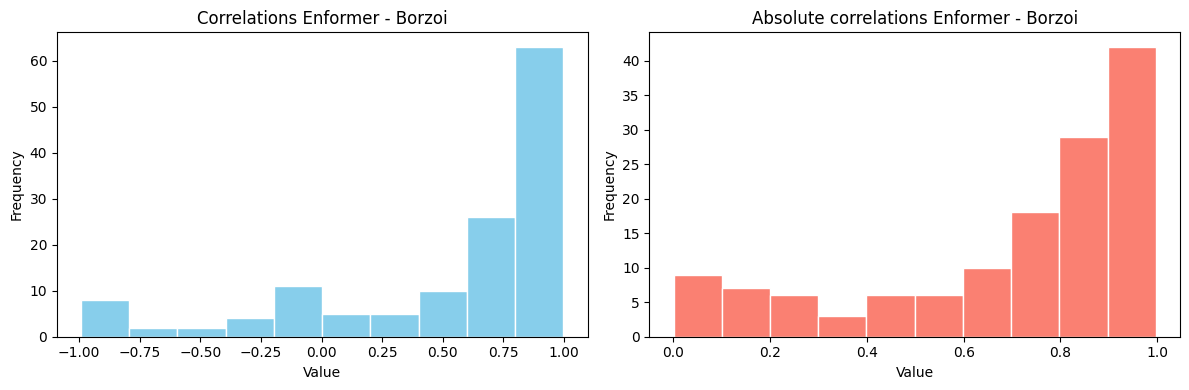

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(best_df_enf_bor['Correlations'], bins=10, color='skyblue', edgecolor='white')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Correlations Enformer - Borzoi')

# Plot the second histogram in the second subplot
axes[1].hist(best_df_enf_bor['abs_Correlations'], bins=10, color='salmon', edgecolor='white')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Absolute correlations Enformer - Borzoi')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

#### Correlations against Ground truth

In [14]:
best_df_against_GT = pd.DataFrame({'Enformer': best_corr_enf_GT,
                             'Borzoi': best_corr_bor_GT,
                             'abs_Enformer': best_corr_enf_GT,
                             'abs_Borzoi': best_corr_bor_GT})
best_df_against_GT['abs_Enformer'] = abs(best_df_against_GT['abs_Enformer'])
best_df_against_GT['abs_Borzoi'] = abs(best_df_against_GT['abs_Borzoi'])
best_df_against_GT.head(10)

,Enformer,Borzoi,abs_Enformer,abs_Borzoi
CDC16,-0.242646,-0.308183,0.242646,0.308183
DPYSL4,0.318979,0.439701,0.318979,0.439701
ZFAND2A,-0.444695,0.386350,0.444695,0.386350
DCAF4,-0.478554,0.248134,0.478554,0.248134
ZFYVE19,-0.017018,0.119285,0.017018,0.119285
MCOLN2,0.440237,0.086427,0.440237,0.086427
XRRA1,0.367341,0.476587,0.367341,0.476587
TTLL12,0.284871,0.278919,0.284871,0.278919
USP40,-0.452123,-0.500160,0.452123,0.500160
UGT2B17,0.399678,0.409415,0.399678,0.409415


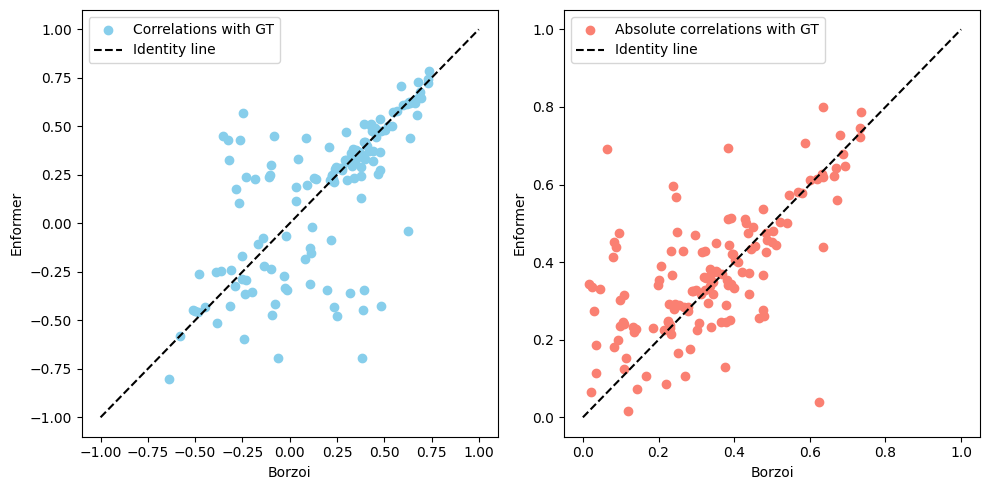

In [51]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(121)
ax1.scatter(best_df_against_GT['Borzoi'], best_df_against_GT['Enformer'], color='skyblue', label='Correlations with GT')
ax1.plot([-1, 1],[-1, 1], color = 'black', linestyle = '--', label = 'Identity line')
ax1.set_xlabel('Borzoi')
ax1.set_ylabel('Enformer')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(best_df_against_GT['abs_Borzoi'], best_df_against_GT['abs_Enformer'], color='salmon', label='Absolute correlations with GT')
ax2.plot([0, 1],[0, 1], color = 'black', linestyle = '--', label = 'Identity line')
ax2.set_xlabel('Borzoi')
ax2.set_ylabel('Enformer')
ax2.legend()

plt.tight_layout()
plt.show()

#### QQ plots of correlations against Ground truth

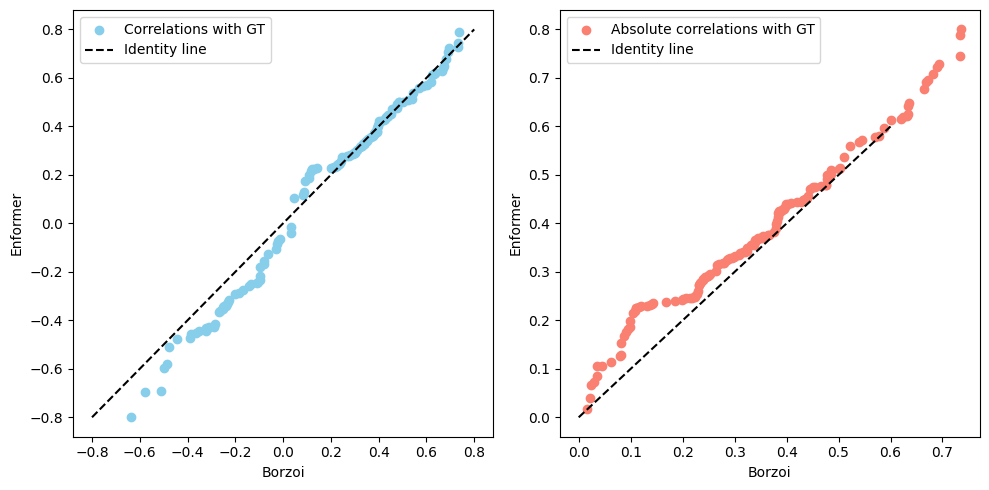

In [62]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(121)
ax1.scatter(sorted(best_df_against_GT['Borzoi']), sorted(best_df_against_GT['Enformer']), color='skyblue', label='Correlations with GT')
ax1.plot([-0.8, 0.80],[-0.8, 0.80], color = 'black', linestyle = '--', label = 'Identity line')
ax1.set_xlabel('Borzoi')
ax1.set_ylabel('Enformer')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(sorted(best_df_against_GT['abs_Borzoi']), sorted(best_df_against_GT['abs_Enformer']), color='salmon', label='Absolute correlations with GT')
ax2.plot([0, 0.6],[0, 0.6], color = 'black', linestyle = '--', label = 'Identity line')
ax2.set_xlabel('Borzoi')
ax2.set_ylabel('Enformer')
ax2.legend()

plt.tight_layout()
plt.show()

## Comparing different bin ranges in borzoi performances

In [52]:
def get_expression_dic2(number_files, software, bins_around):
    expression_dic = {k:{} for k in individuals}
    start_bin = (9 - bins_around) if software.lower() == 'borzoi' else 3
    end_bin = (9 + bins_around) if software.lower() == 'borzoi' else 7
    index = [870, 871] if software.lower()== 'borzoi' else 5110
    for individual in individuals:
        gene_expr = {}
        for file_num in range(1, number_files + 1):
            with h5py.File('/scratch/midway3/t-9ssal0/h5_files/' + software.lower() + '_predictions'+ str(file_num)+ '.h5', 'r') as file:
                for gene in best_genes_per_file[file_num - 1]: #iterate through genes in file
                    group = file[individual]
                    expression = 0
                    for h in range(0,2): # iterate through haplotypes
                        prediction = group[f'{gene}_haplo{h}'][:, index]
                        if software.lower() == 'borzoi':
                            prediction = np.mean(prediction, axis = (1)) # mean over track replicates
                        expression += np.mean(prediction[start_bin: end_bin])
                    gene_expr[gene] = expression
                    del prediction
        expression_dic[individual] = gene_expr
    return expression_dic


In [53]:
expression_borzoi_8 = get_expression_dic2(7,'borzoi', 4)
borzoi_across_individuals_8 = get_predictions_across_indiv(expression_borzoi_8, best_my_genes)

In [56]:
expression_borzoi_4 = get_expression_dic2(7, 'borzoi', 2)
borzoi_across_individuals_4 = get_predictions_across_indiv(expression_borzoi_4, best_my_genes)

In [57]:
expression_borzoi_2 = get_expression_dic2(7, 'borzoi', 1)
borzoi_across_individuals_2 = get_predictions_across_indiv(expression_borzoi_2, best_my_genes)

In [58]:
corr_borzoi_8 = get_correlations(borzoi_across_individuals_8, best_GT_across)
corr_borzoi_4 = get_correlations(borzoi_across_individuals_4, best_GT_across)
corr_borzoi_2 = get_correlations(borzoi_across_individuals_2, best_GT_across)

In [59]:
bin_ranges_df = pd.DataFrame({'Borzoi 16 bins': best_corr_bor_GT,
                              'Borzoi 8 bins': corr_borzoi_8,
                              'Borzoi 4 bins': corr_borzoi_4,
                              'Borzoi 2 bins': corr_borzoi_2})
bin_ranges_df.head(10)

,Borzoi 16 bins,Borzoi 8 bins,Borzoi 4 bins,Borzoi 2 bins
CDC16,-0.308183,-0.173212,-0.097312,0.064835
DPYSL4,0.439701,0.442904,0.438260,0.057265
ZFAND2A,0.386350,0.386898,0.043857,0.544630
DCAF4,0.248134,0.519006,0.557798,0.529078
ZFYVE19,0.119285,0.125048,0.367074,-0.365466
MCOLN2,0.086427,-0.420791,-0.507746,-0.510637
XRRA1,0.476587,0.488511,0.541467,0.566548
TTLL12,0.278919,0.278045,0.274921,0.302587
USP40,-0.500160,-0.493973,-0.475467,-0.469835
UGT2B17,0.409415,0.402573,0.391174,0.389104


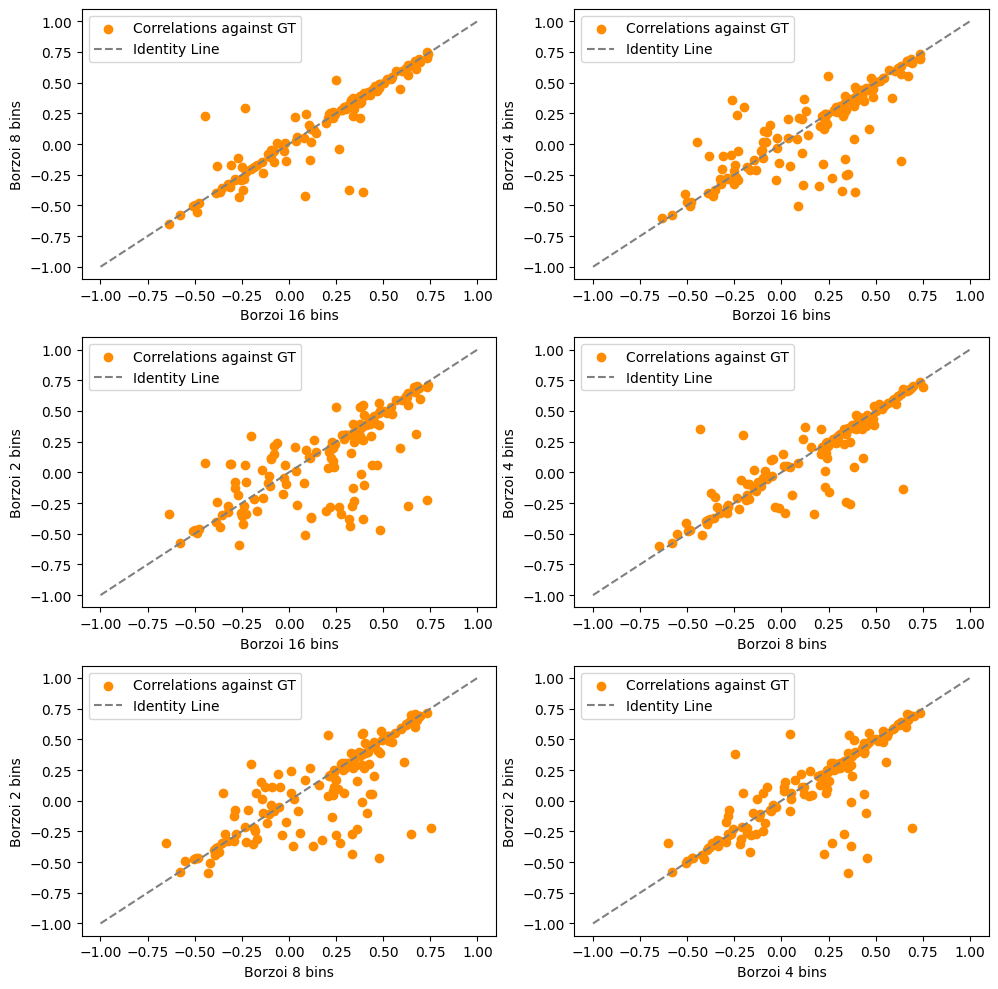

In [60]:
import itertools
column_combinations = list(itertools.combinations(bin_ranges_df.columns, 2))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, (col1, col2) in enumerate(column_combinations):
    row, col = divmod(i, 2)  # Calculate the row and column for the current subplot
    ax = axes[row, col]  # Select the current subplot

    # Plot the data (customize this part as needed)
    ax.scatter(bin_ranges_df[col1], bin_ranges_df[col2], color='darkorange', label='Correlations against GT')
    ax.plot([-1, 1], [-1, 1], color='gray', linestyle='--', label='Identity Line')
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Second analysis: performance comparison in worst-performing genes with Enformer

#### Get expression across individuals for each gene

In [16]:
worst_expression_borzoi_dic = get_expression_dic(7, 'borzoi', 'worst', worst_genes_per_file)
worst_expression_enformer_dic = get_expression_dic(7, 'enformer', 'worst', worst_genes_per_file)

worst_borzoi_across_individuals = get_predictions_across_indiv(worst_expression_borzoi_dic, worst_my_genes)
worst_enformer_across_individuals = get_predictions_across_indiv(worst_expression_enformer_dic, worst_my_genes)

In [19]:
geuvadis = geuvadis_gene_expression.loc[geuvadis_gene_expression['gene_name'].isin(worst_my_genes)]
geuvadis.index = geuvadis['gene_name']
geuvadis = geuvadis.loc[:, individuals]
geuvadis = geuvadis.loc[worst_my_genes]
worst_GT_across = {gene:val for gene, val in zip(worst_my_genes, geuvadis.values.tolist())}

### Correlations

In [20]:
worst_corr_borzoi_enf = get_correlations(worst_borzoi_across_individuals, worst_enformer_across_individuals)
worst_corr_enf_GT = get_correlations(worst_enformer_across_individuals, worst_GT_across)
worst_corr_bor_GT = get_correlations(worst_borzoi_across_individuals, worst_GT_across)

#### Correlations between enformer and borzoi predictions

In [21]:
worst_df_enf_bor = pd.DataFrame({'Correlations': worst_corr_borzoi_enf,
                           'abs_Correlations':worst_corr_borzoi_enf})
worst_df_enf_bor['abs_Correlations'] = abs(worst_df_enf_bor['abs_Correlations'])
worst_df_enf_bor.head(10)

,Correlations,abs_Correlations
ATP6V1E2,0.052960,0.052960
ZNF384,0.672741,0.672741
SART3,0.732671,0.732671
SLC15A2,-0.523820,0.523820
AKR7A2,0.075323,0.075323
GBP1,0.513649,0.513649
ZNF624,-0.668723,0.668723
MRTO4,-0.090715,0.090715
CD84,0.076973,0.076973
RAB40B,-0.690359,0.690359


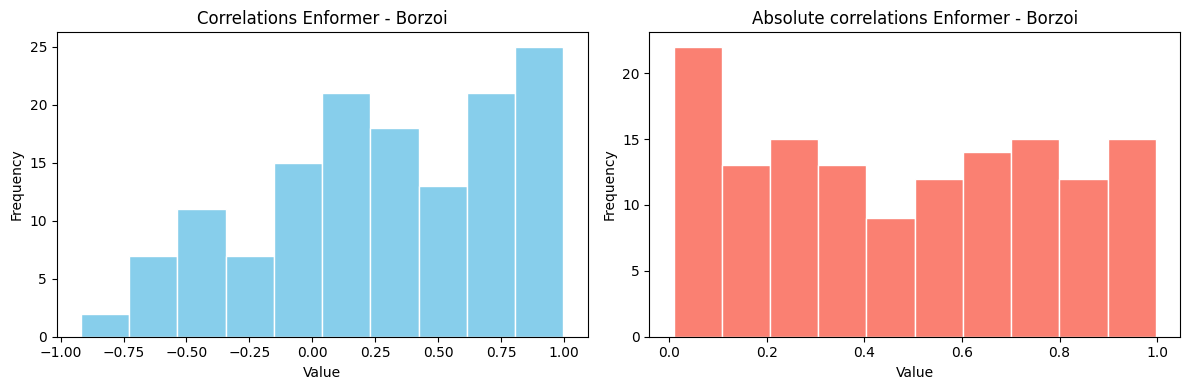

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(worst_df_enf_bor['Correlations'], bins=10, color='skyblue', edgecolor='white')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Correlations Enformer - Borzoi')

# Plot the second histogram in the second subplot
axes[1].hist(worst_df_enf_bor['abs_Correlations'], bins=10, color='salmon', edgecolor='white')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Absolute correlations Enformer - Borzoi')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

#### Correlations against Ground truth

In [23]:
worst_df_against_GT = pd.DataFrame({'Enformer': worst_corr_enf_GT,
                             'Borzoi': worst_corr_bor_GT,
                             'abs_Enformer': worst_corr_enf_GT,
                             'abs_Borzoi': worst_corr_bor_GT})
worst_df_against_GT['abs_Enformer'] = abs(worst_df_against_GT['abs_Enformer'])
worst_df_against_GT['abs_Borzoi'] = abs(worst_df_against_GT['abs_Borzoi'])
worst_df_against_GT.head(10)

,Enformer,Borzoi,abs_Enformer,abs_Borzoi
ATP6V1E2,0.164837,0.322586,0.164837,0.322586
ZNF384,0.079999,0.129734,0.079999,0.129734
SART3,-0.031612,-0.124788,0.031612,0.124788
SLC15A2,-0.078513,0.076483,0.078513,0.076483
AKR7A2,-0.107319,0.280086,0.107319,0.280086
GBP1,-0.167450,-0.006239,0.167450,0.006239
ZNF624,0.037769,0.005369,0.037769,0.005369
MRTO4,-0.255579,0.036356,0.255579,0.036356
CD84,0.096425,0.063115,0.096425,0.063115
RAB40B,-0.045073,0.052897,0.045073,0.052897


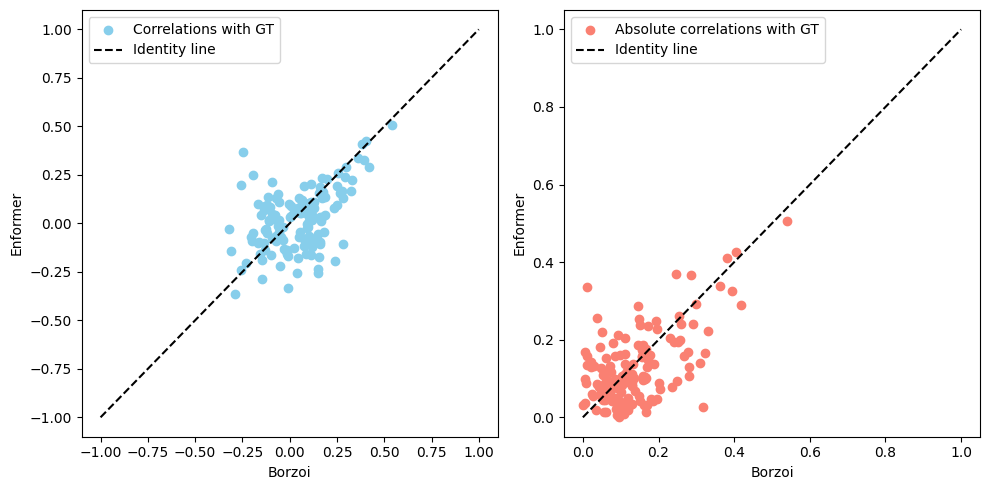

In [47]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(121)
ax1.scatter(worst_df_against_GT['Borzoi'], worst_df_against_GT['Enformer'], color='skyblue', label='Correlations with GT')
ax1.plot([-1, 1],[-1, 1], color = 'black', linestyle = '--', label = 'Identity line')
ax1.set_xlabel('Borzoi')
ax1.set_ylabel('Enformer')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(worst_df_against_GT['abs_Borzoi'], worst_df_against_GT['abs_Enformer'], color='salmon', label='Absolute correlations with GT')
ax2.plot([0, 1],[0, 1], color = 'black', linestyle = '--', label = 'Identity line')
ax2.set_xlabel('Borzoi')
ax2.set_ylabel('Enformer')
ax2.legend()

plt.tight_layout()
plt.show()

#### QQ plots of correlations against ground truth

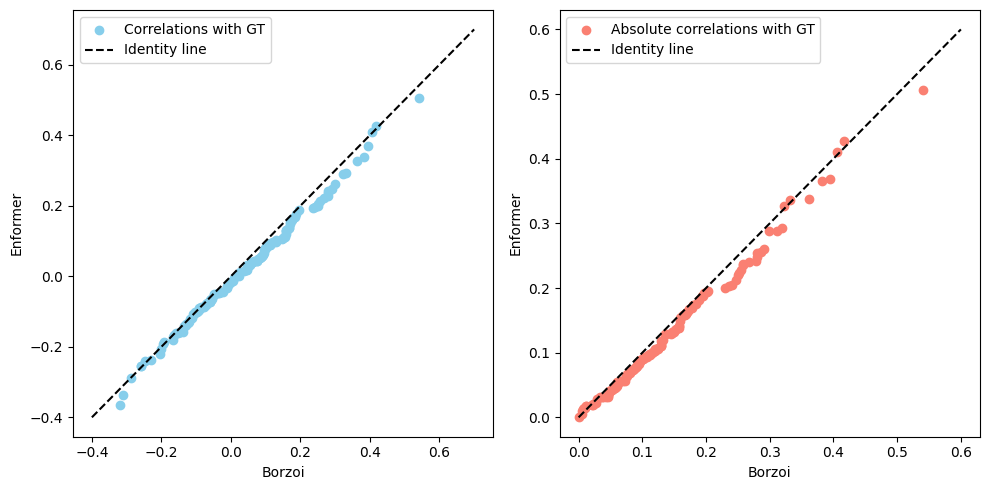

In [49]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(121)
ax1.scatter(sorted(worst_df_against_GT['Borzoi']), sorted(worst_df_against_GT['Enformer']), color='skyblue', label='Correlations with GT')
ax1.plot([-0.4, 0.70],[-0.4, 0.70], color = 'black', linestyle = '--', label = 'Identity line')
ax1.set_xlabel('Borzoi')
ax1.set_ylabel('Enformer')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(sorted(worst_df_against_GT['abs_Borzoi']), sorted(worst_df_against_GT['abs_Enformer']), color='salmon', label='Absolute correlations with GT')
ax2.plot([0, 0.6],[0, 0.6], color = 'black', linestyle = '--', label = 'Identity line')
ax2.set_xlabel('Borzoi')
ax2.set_ylabel('Enformer')
ax2.legend()

plt.tight_layout()
plt.show()

# Sabrina's Analysis

## Collecting Results

In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col="ensembl_gene_id")
seq_len = 524288
seq_out_len = 523264
prefix = "/home/s1mi/Github/deep-learning-in-genomics/posts/2023-10-20-borzoi-vs-enformer-personalized-prediction"
predictions_dir = "/eagle/AIHPC4Edu/sabrina/borzoi-personalized-predictions"
with open(f"{prefix}/individuals.txt", "r") as f:
    individuals = f.read().splitlines()
with open(f"{prefix}/completed_intervals.txt", "r") as f:
    intervals = f.read().splitlines()
# with open("intervals.txt", "r") as f:
#     intervals.extend(f.read().splitlines()[:5]) # test on first few genes


In [2]:
gene_list = []
for interval in intervals:
    split_interval = interval.split("_")
    chr = split_interval[0][3:]
    tss = int(split_interval[1])
    gene = hg38_annot.index[(hg38_annot['chromosome_name'] == chr) & (hg38_annot['transcription_start_site'] == tss)]
    gene_list.append(gene.item())

In [3]:
CAGE_dict = {gene: [] for gene in gene_list}
for index, gene in enumerate(gene_list):
    interval = intervals[index]
    for individual in individuals: 
        predictions_file = os.path.join(predictions_dir, individual, f'{interval}_predictions.h5')
        if os.path.exists(predictions_file):
            with h5py.File(predictions_file, "r") as hf:
                haplo1 = np.mean(hf['haplotype1'][:, 1:9, :])
                haplo2 = np.mean(hf['haplotype2'][:, 1:9, :])
                prediction = (haplo1 + haplo2)/2
            CAGE_dict[gene].append(prediction)
        else:
            CAGE_dict[gene].append(np.nan)


In [4]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)

In [5]:
expr_dict = {}
for gene in gene_list:
    observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])
    expr_df = pd.DataFrame({'Observed': observed, "Predicted": CAGE_dict[gene]}, index = individuals)
    expr_dict[gene] = expr_df.dropna()


In [6]:
pearson_corr_by_gene = pd.DataFrame(columns=["Pearson R", "P-value"], index = gene_list)
for gene in gene_list:
    corr, pval = stats.pearsonr(expr_dict[gene]["Observed"], expr_dict[gene]["Predicted"])
    pearson_corr_by_gene.loc[gene] = [corr, pval]

In [7]:
spearman_corr_by_gene = pd.DataFrame(columns=["Spearman R", "P-value"], index = gene_list)
for gene in gene_list:
    corr, pval = stats.spearmanr(expr_dict[gene]["Observed"], expr_dict[gene]["Predicted"])
    spearman_corr_by_gene.loc[gene] = [corr, pval]

### Borzoi's Best Performing Gene 

**(out of the first 47 randomly-sampled genes)** ENSG00000137265 was the best performing gene (both for Spearman and Pearson R) for Borzoi's personalized prediction. 


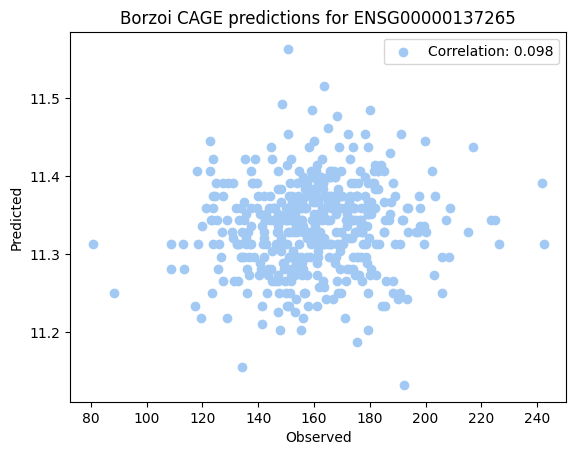

In [8]:
colors = sns.color_palette("pastel")
gex_df = expr_dict['ENSG00000137265']
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")


# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE predictions for ENSG00000137265")

# Show the plot
plt.legend()
plt.show()

## Compare Correlations to Enformer

In [10]:
enformer_corr_df = pd.read_csv(f"{prefix}/enformer_geuvadis_correlations.csv").dropna()
enformer_corr = []
for gene in gene_list:
    gene_name = hg38_annot.loc[gene]['external_gene_name']
    corr = enformer_corr_df['ge'][enformer_corr_df['gene_names'] == gene_name]
    enformer_corr.append(corr.item())

In [11]:
spearman_corr_by_gene["Enformer"] = enformer_corr
spearman_corr_by_model = spearman_corr_by_gene.rename(columns={"Spearman R": "Borzoi"}).drop(columns=["P-value"])

In [12]:
spearman_corr_by_model.head()

,Borzoi,Enformer
ENSG00000011638,0.097914,0.241614
ENSG00000112031,0.036816,-0.007003
ENSG00000172732,0.022511,0.078569
ENSG00000173638,0.112324,-0.084114
ENSG00000156535,0.084083,0.031968


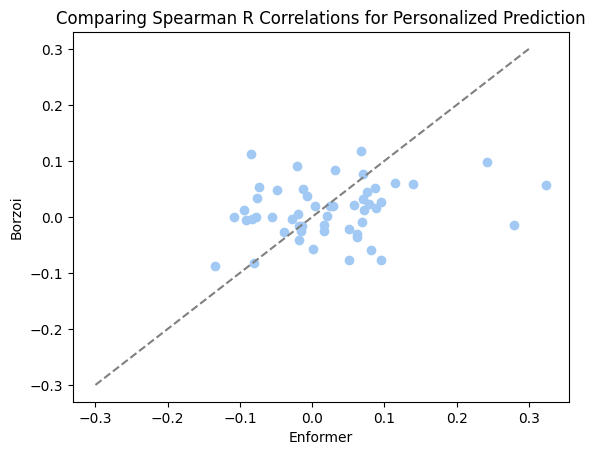

In [13]:
colors = sns.color_palette("pastel")
plt.scatter(spearman_corr_by_model['Enformer'], spearman_corr_by_model['Borzoi'], marker='o', color=colors[0])
line = np.linspace(-0.3, 0.3)
plt.plot(line, line, label='y = x', color='gray', linestyle='--')
# Add labels and title
plt.xlabel("Enformer")
plt.ylabel("Borzoi")
plt.title("Comparing Spearman R Correlations for Personalized Prediction")

plt.show()

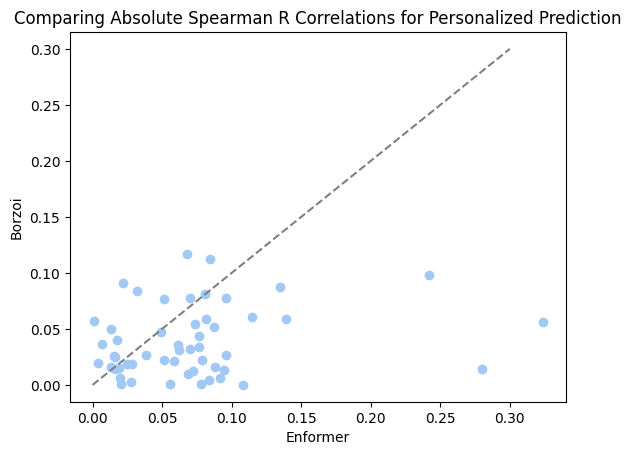

In [14]:
colors = sns.color_palette("pastel")
plt.scatter(spearman_corr_by_model['Enformer'].abs(), spearman_corr_by_model['Borzoi'].abs(), marker='o', color=colors[0])
line = np.linspace(0, 0.3)
plt.plot(line, line, label='y = x', color='gray', linestyle='--')
# Add labels and title
plt.xlabel("Enformer")
plt.ylabel("Borzoi")
plt.title("Comparing Absolute Spearman R Correlations for Personalized Prediction")

plt.show()

### Bin Sizing

We used a 4 bin window centered at the TSS for each CAGE computation, we want to see which bin width gives the best estimate.

In [15]:
CAGE_dicts = [{gene: [] for gene in gene_list} for i in range(5)]
for index, gene in enumerate(gene_list):
    interval = intervals[index]
    for individual in individuals: 
        predictions_file = os.path.join(predictions_dir, individual, f'{interval}_predictions.h5')
        if os.path.exists(predictions_file):
            with h5py.File(predictions_file, "r") as hf:
                for i in range(5): 
                    haplo1 = np.mean(hf['haplotype1'][:, 4-i:6+i, :])
                    haplo2 = np.mean(hf['haplotype2'][:, 4-i:6+i, :])
                    prediction = (haplo1 + haplo2)/2
                    CAGE_dicts[i][gene].append(prediction)
        else:
            for i in range(5):
                CAGE_dicts[i][gene].append(np.nan)

In [ ]:
spearman_corr_by_bin_size = pd.DataFrame({"Enformer": enformer_corr}, index=gene_list)
for i in range(5):
    results =[]
    for gene in gene_list:
        observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])
        predicted = CAGE_dicts[i][gene]
        corr, _ = stats.spearmanr(observed, predicted)
        results.append(corr)
    spearman_corr_by_bin_size[f'Borzoi, {2*(i+1)} bins'] = results


In [ ]:
def histogram(x, title):
    plt.hist(x, bins=10, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
    plt.title(title)
    plt.xlabel('Spearman Correlations')
    plt.ylabel('Frequency')
    mean = np.mean(x)
    plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    plt.legend()

    # Display the plot
    plt.show()

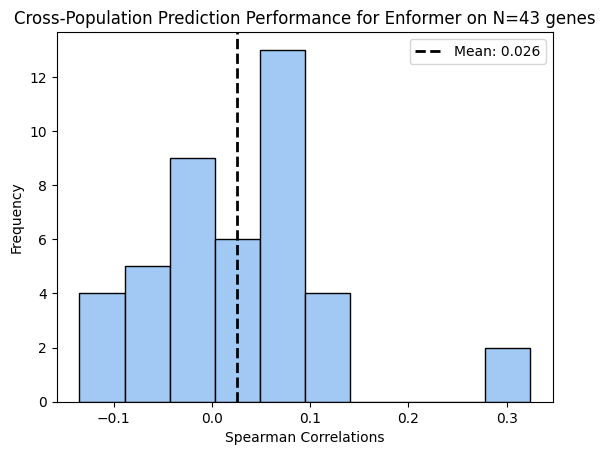

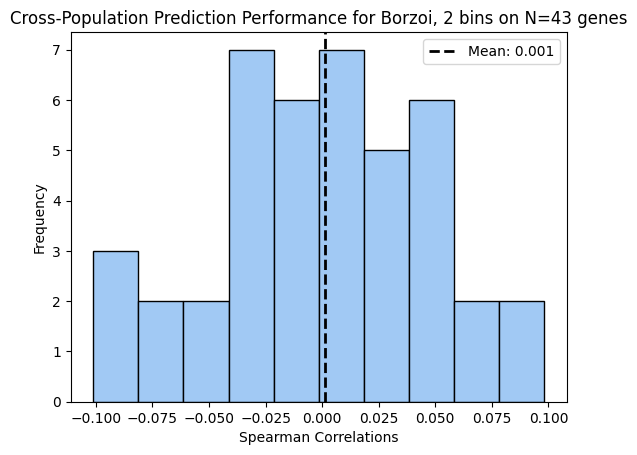

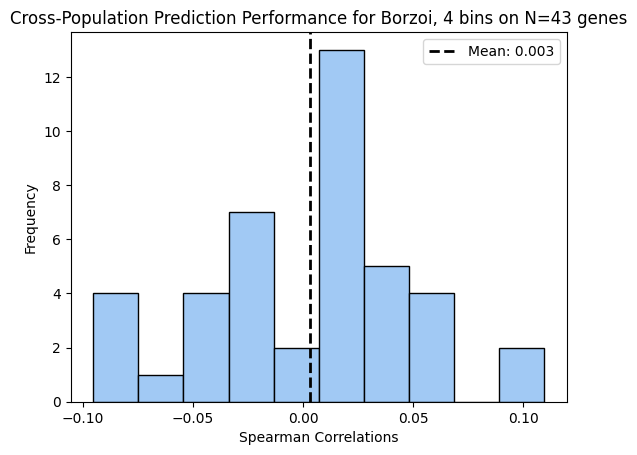

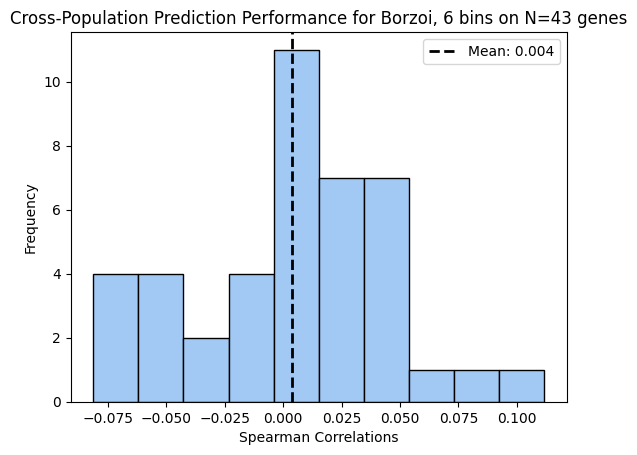

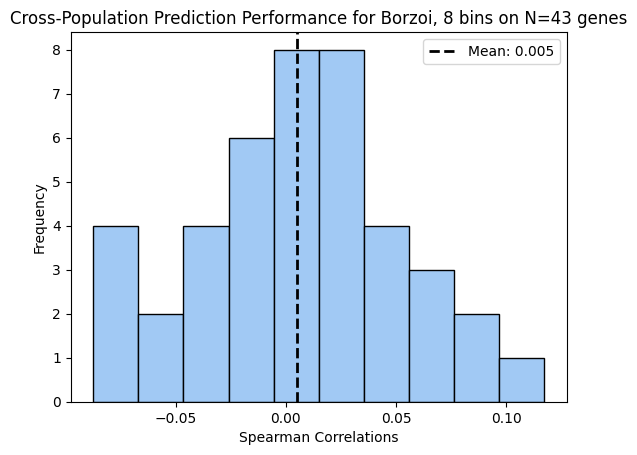

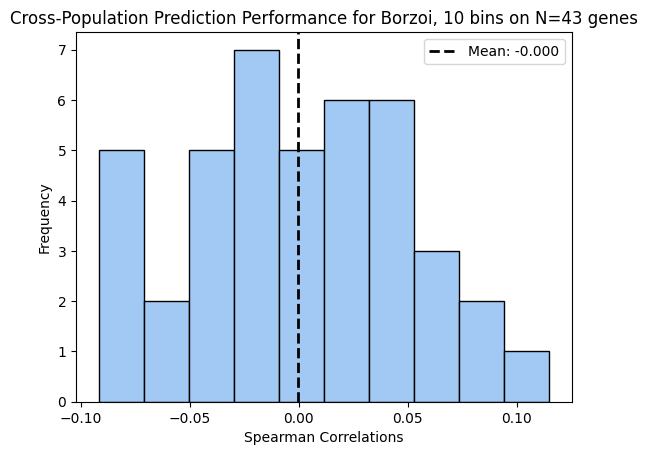

In [ ]:
for column in spearman_corr_by_bin_size:
    n = len(gene_list)
    x = spearman_corr_by_bin_size[column]
    histogram(x, title=f'Cross-Population Prediction Performance for {column} on N={n} genes')

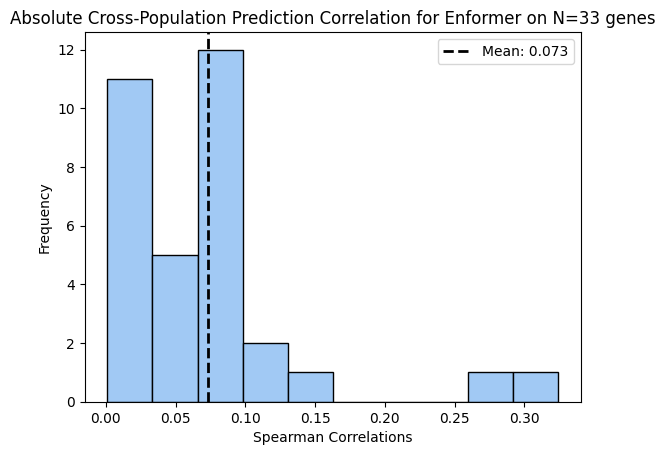

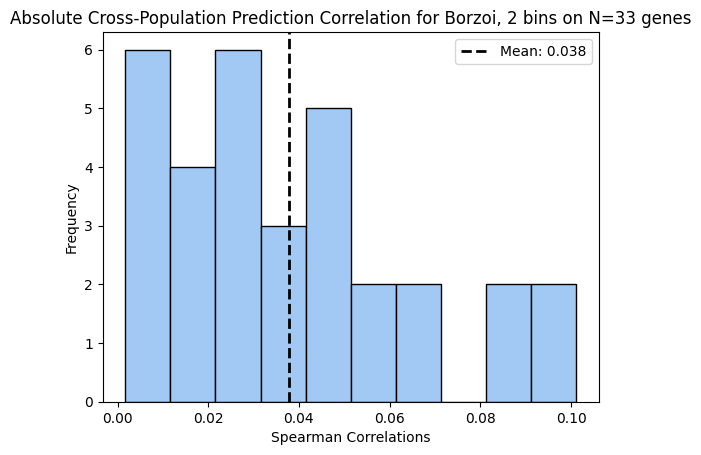

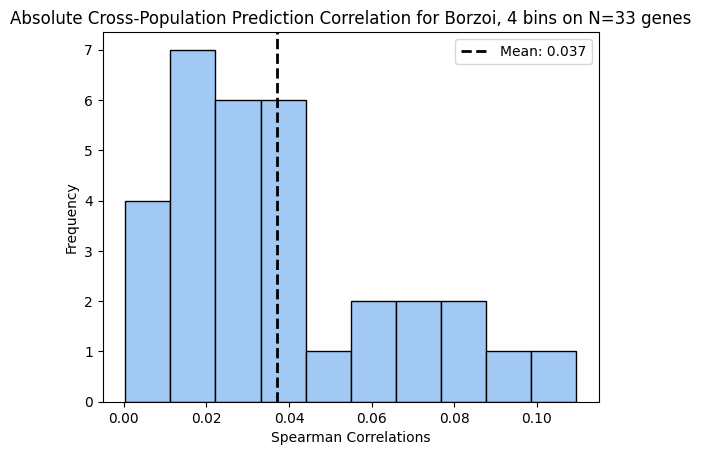

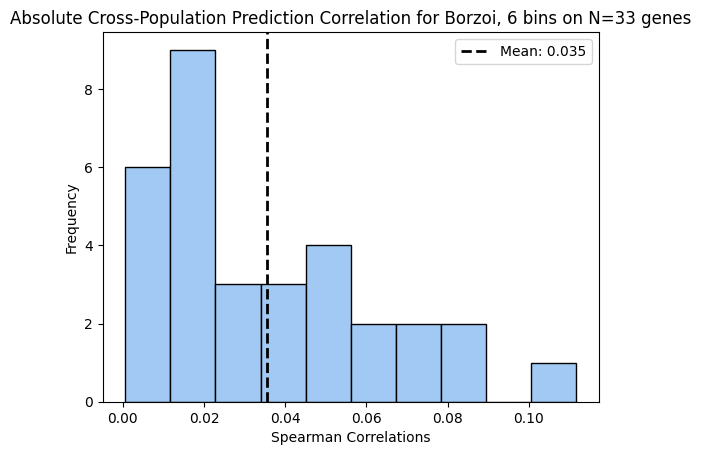

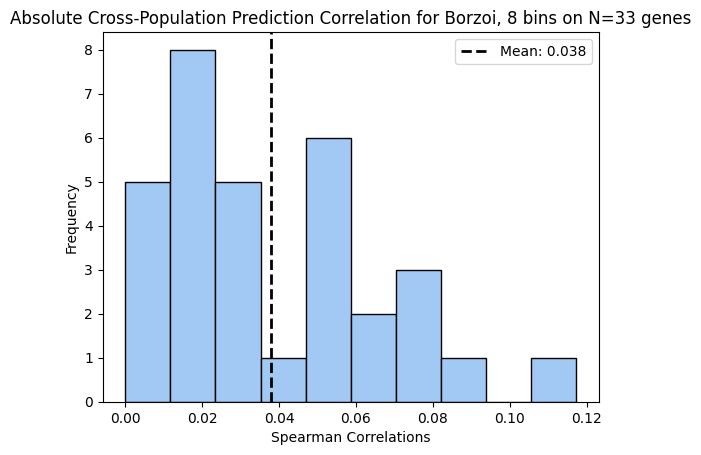

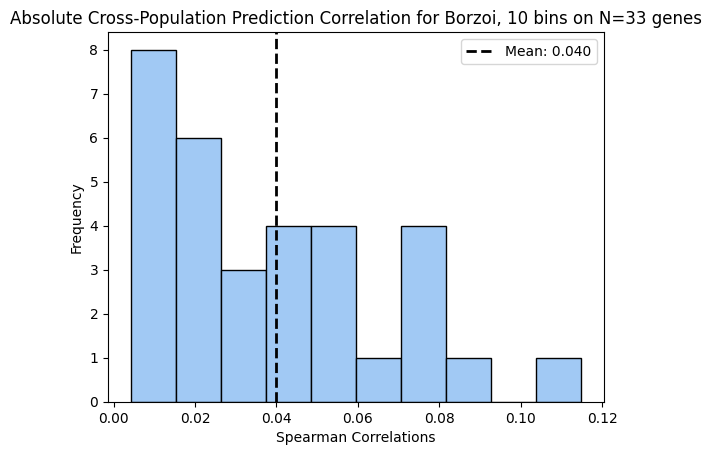

In [46]:
for column in spearman_corr_by_bin_size:
    n = len(gene_list)
    x = spearman_corr_by_bin_size[column].abs()
    histogram(x, title=f'Absolute Cross-Population Prediction Correlation for {column} on N={n} genes')

In [43]:
model_perf_dict = {column: 0 for column in spearman_corr_by_bin_size}
for index, row in spearman_corr_by_bin_size.iterrows():
    best_model = spearman_corr_by_bin_size.loc[index].idxmax()
    model_perf_dict[best_model] += 1
model_abs_perf_dict = {column: 0 for column in spearman_corr_by_bin_size}
for index, row in spearman_corr_by_bin_size.iterrows():
    best_model = spearman_corr_by_bin_size.abs().loc[index].idxmax()
    model_abs_perf_dict[best_model] += 1
print("Highest Correlation Model:")
print(model_perf_dict)
print("Highest Absolute Valued Correlation Model:")
print(model_abs_perf_dict)

Highest Correlation Model:
{'Enformer': 19, 'Borzoi, 2 bins': 4, 'Borzoi, 4 bins': 2, 'Borzoi, 6 bins': 2, 'Borzoi, 8 bins': 4, 'Borzoi, 10 bins': 2}
Highest Absolute Valued Correlation Model:
{'Enformer': 20, 'Borzoi, 2 bins': 4, 'Borzoi, 4 bins': 3, 'Borzoi, 6 bins': 1, 'Borzoi, 8 bins': 4, 'Borzoi, 10 bins': 1}


## Conclusions

After these analysis, we can conclude that predictions with borzoi are not significantly different, in performance terms, than enformer. While it does seem that borzoi improves the performance for those genes that previously performed bad with enformer, the improvement is not significant. Additionally, borzoi doesn't improve predictive performance for the genes that already performed well with enformer.

It should be noted that these analysis are limited by the number of individuals and the small sample of genes that I considered. Also, they are based only on the CAGE LCL track(s), yet, it's important to remember that borzoi does predict for RNA-seq tracks while enformer does not.